In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as scisp
import dataclasses as dc

In [131]:
def RobinHelper(alpha,beta,gamma,h, outward = True):
   sign = 1 if outward else -1
   lapmod = -2*alpha/(beta*h) * sign
   rhsmod = 2*gamma/(beta*h) * sign
   return lapmod, rhsmod


def ConstructLaplacian(rgf,zgf,Nrf,Nzf,hrf,hzf, bcs: LaplacianBCs):
   Ntot = Nrf * Nzf
   lapmat = scisp.lil_matrix((Ntot, Ntot))
   rhs = np.zeros(Ntot)
   def idx(i, j):
      return j * Nrf + i

   for j in range(Nzf): #Build matrix
      for i in range(Nrf):
         on_left = (i == 0)
         on_right = (i == Nrf - 1)
         on_bottom = (j == 0)
         on_top = (j == Nzf - 1)
         k = idx(i, j)
         lapmat[k, k] = -2 / hrf**2 - 2 / hzf**2 # diagonal element
         if i == 0:
            # Special axis stencil: diagonal gets -4/hrf² instead of -2/hrf²
            lapmat[k, k] += -2/hrf**2  # Add extra -2/hrf² to base diagonal
            lapmat[k, idx(i+1, j)] = 4/hrf**2  # Right neighbor (no cylindrical term)
         elif i < Nrf - 1:
            # Interior: left neighbor
            lapmat[k, idx(i-1, j)] = 1/hrf**2 - 1/(2*rgf[i]*hrf)
            # Interior: right neighbor  
            lapmat[k, idx(i+1, j)] = 1/hrf**2 + 1/(2*rgf[i]*hrf)
         else:
            # i == Nrf-1: outer boundary
            lapmat[k, idx(i-1, j)] = 1/hrf**2 - 1/(2*rgf[i]*hrf)
            alpha,beta,gamma = bcs.r_outer.alpha[j], bcs.r_outer.beta[j], bcs.r_outer.gamma[j]
            lapmod, rhsmod = RobinHelper(alpha,beta,gamma,hrf)
            lapmat[k, k] += lapmod + 1/hrf**2
            rhs[k] += rhsmod


         if j > 0:
            lapmat[k, idx(i, j-1)] = 1 / hzf**2 # bottom neighbor
         else:
            alpha,beta,gamma = bcs.z_inner.alpha[i], bcs.z_inner.beta[i], bcs.z_inner.gamma[i]
            lapmod, rhsmod = RobinHelper(alpha,beta,gamma,hzf, outward=False)
            lapmat[k, k] += lapmod + 1/hzf**2
            rhs[k] += rhsmod

         if j < Nzf - 1:
            lapmat[k, idx(i, j+1)] = 1 / hzf**2 # top neighbor
         else:
            alpha,beta,gamma = bcs.z_outer.alpha[i], bcs.z_outer.beta[i], bcs.z_outer.gamma[i]
            lapmod, rhsmod = RobinHelper(alpha,beta,gamma,hzf)
            lapmat[k, k] += lapmod + 1/hzf**2
            rhs[k] += rhsmod

   return lapmat.tocsr(), rhs



def alpha_anzatz(rgf, E0omf, rmaxguessf):
  return (E0omf + (rgf - rmaxguessf)/(2.0*rmaxguessf))/(1 + (rgf - rmaxguessf)/(2.0*rmaxguessf))


def sigma(rgf,lapf, E0omf, rmaxguessf, K0f, Mguessf):
  result = (rgf <= rmaxguessf)*2*np.pi*K0f*E0omf*lapf**(-3.0)/Mguessf
  return result
         

            
class RazorThinDisk:
   def __init__(self, Nr, Nz, E0oM):
         self.Nr = Nr
         self.Nz = Nz

         self.E0oM = E0oM
         self.Mguess = 1.0 # Initial guess for M_ADM
         self.rmaxguess = self.Mguess*0.5*(1 + self.E0oM)/(1 - self.E0oM)
         self.K0 = 1.0 ;

         self.rmin = 1e-1; self.rmax = 10.0*self.Mguess
         self.zmin = 0.0; self.zmax = 10.0*self.Mguess
         self.Lr = self.rmax - self.rmin; self.Lz = self.zmax - self.zmin;
         self.hr, self.hz = self.Lr/(self.Nr - 1), self.Lz/(self.Nz - 1)

         self.rhog = np.linspace(self.rmin, self.rmax, self.Nr, endpoint = True)
         self.zg = np.linspace(self.zmin, self.zmax, self.Nz, endpoint = True)
         self.rhog2d, self.zg2d = np.meshgrid(self.rhog, self.zg, indexing='ij')
         self.r_disp = np.sqrt(self.rhog2d**2 + self.zg2d**2)
        
         self.r_top = np.sqrt(self.rhog**2 + self.zg[-1]**2)
         self.r_right = np.sqrt(self.rhog[-1]**2 + self.zg**2)

         self.alpha_old = alpha_anzatz(self.rhog, self.E0oM, self.rmaxguess)
         self.psi_old = np.ones(Nr)
         self.sigma_old = sigma(self.rhog, self.alpha_old, self.E0oM, self.rmaxguess, self.K0, self.Mguess)

         self.bcs = LaplacianBCs(
            r_inner = RobinBC(alpha=np.zeros(Nz), beta=np.ones(Nz), gamma=np.zeros(Nz)), #r-
            r_outer = RobinBC(alpha=np.ones(Nz), beta=self.r_right/self.rhog[-1], gamma=np.ones(Nz)), #r+
            z_inner = RobinBC(alpha=5*np.pi*(self.psi_old**4)*self.sigma_old, beta=np.ones(Nr), gamma=4*np.pi*self.psi_old**5*self.sigma_old), #z-
            z_outer = RobinBC(alpha=np.ones(Nr), beta=self.r_top/self.zg[-1], gamma=np.ones(Nr))  #z+
         )

         self.lapmat, self.rhs = ConstructLaplacian(self.rhog, self.zg, self.Nr, self.Nz, self.hr, self.hz, self.bcs)

         print("rhs norm", np.linalg.norm(self.rhs))
         print("A nnz", self.lapmat.nnz)
         print("A shape", self.lapmat.shape)

   def solve(self):
      #u, info = scisp.linalg.gmres(self.lapmat, self.rhs, rtol=1e-8)
      #print(info)
      self.ures= scisp.linalg.spsolve(self.lapmat, self.rhs)
      
      self.res = self.lapmat @ self.ures - self.rhs
      print("res norm", np.linalg.norm(self.res))
      print("rel res", np.linalg.norm(self.res)/np.linalg.norm(self.rhs))





   def Visualize(self, ures):
      ures2d = ures.reshape((self.Nz, self.Nr), order='C').T
      plt.figure()
      plt.imshow(ures2d.T, origin='lower', extent=(self.rmin, self.rmax, self.zmin, self.zmax))
      plt.colorbar(label='u')
      plt.xlabel('r')
      plt.ylabel('z')
      plt.title('Solution u(r,z)')
      
   def Visualize1D(self, ures):
      ures2d = ures.reshape((self.Nz, self.Nr), order='C').T
      
      zslices = np.arange(0, self.Nz, self.Nz//5)
      rslices = np.arange(0, self.Nr, self.Nr//5)
      zidx = np.array([np.argmin(np.abs(self.zg - self.zg[zslices[i]])) for i in range(len(zslices))])
      ridx = np.array([np.argmin(np.abs(self.rhog - self.rhog[rslices[i]])) for i in range(len(rslices))])
      fig, axs = plt.subplots(1, 2, figsize=(15, 5))
      axs[0].plot(self.rhog, ures2d[:,zidx], "-o", label=[f'z={self.zg[idx]:.2f}' for idx in zidx])
      axs[0].axvline(x =self.rmaxguess,c='k',ls='--')
      axs[0].set_xlabel('r')
      axs[0].set_ylabel('u')
      axs[0].set_title('Solution u(r, z=idx)')
      axs[0].legend()
      axs[0].grid()
      axs[1].plot(self.zg, ures2d[ridx,:].T, "-o", label=[f'r={self.rhog[idx]:.2f}' for idx in ridx])
      #axs[1].plot(self.zg, ures2d[0,10]*(self.r_disp[0,10])/self.r_disp[:,10] - 1.0, "--",c='k')
      axs[1].axvline(x =self.zg[-1],c='k',ls='--')
      axs[1].set_xlabel('z')
      axs[1].set_ylabel('u')
      axs[1].set_title('Solution u(r=idx, z)')
      axs[1].legend()
      axs[1].grid()

   def VisualizeSigmaAlphaPsi(self, sigma,alpha,psi):
      fig, axs = plt.subplots(1, 3, figsize=(15, 5))
      axs[0].plot(self.rhog, sigma, "-o")
      axs[0].axvline(x =self.rmaxguess,c='k',ls='--')
      axs[0].set_title('Sigma(r)')
      axs[0].set_xlabel('r')
      axs[0].set_ylabel('Sigma')
      axs[1].plot(self.rhog, alpha, "-o")
      axs[1].axvline(x =self.rmaxguess,c='k',ls='--')
      axs[1].set_title('Alpha(r)')
      axs[1].set_xlabel('r')
      axs[1].set_ylabel('Alpha')
      axs[2].plot(self.rhog, psi, "-o")
      axs[2].axvline(x =self.rmaxguess,c='k',ls='--')
      axs[2].set_title('Psi(r)')
      axs[2].set_xlabel('r')
      axs[2].set_ylabel('Psi')
      plt.tight_layout()
      



@dc.dataclass
class RobinBC:
    alpha: np.ndarray
    beta: np.ndarray
    gamma:  np.ndarray

@dc.dataclass
class LaplacianBCs:
   r_inner: RobinBC
   r_outer: RobinBC
   z_inner: RobinBC
   z_outer: RobinBC


Rdisk = RazorThinDisk(Nr=100, Nz=110, E0oM=0.8)
Rdisk.solve()



rhs norm 25927.274956159607
A nnz 54580
A shape (11000, 11000)
res norm 7.4489987973352e-12
rel res 2.873035754791316e-16


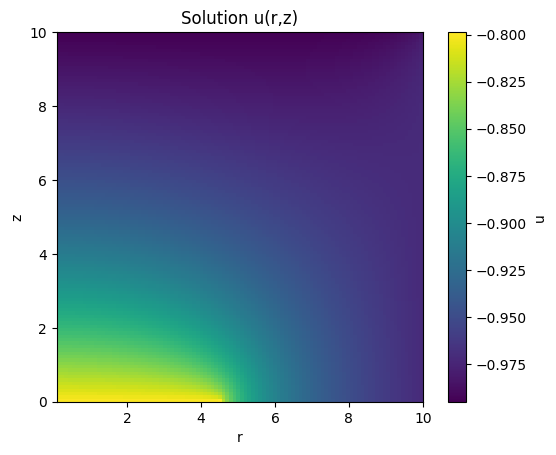

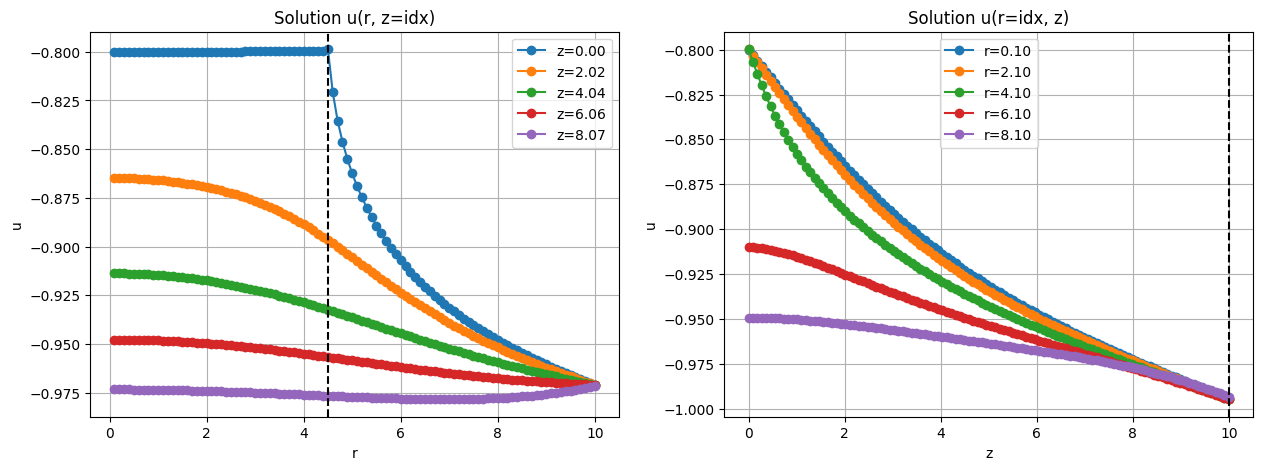

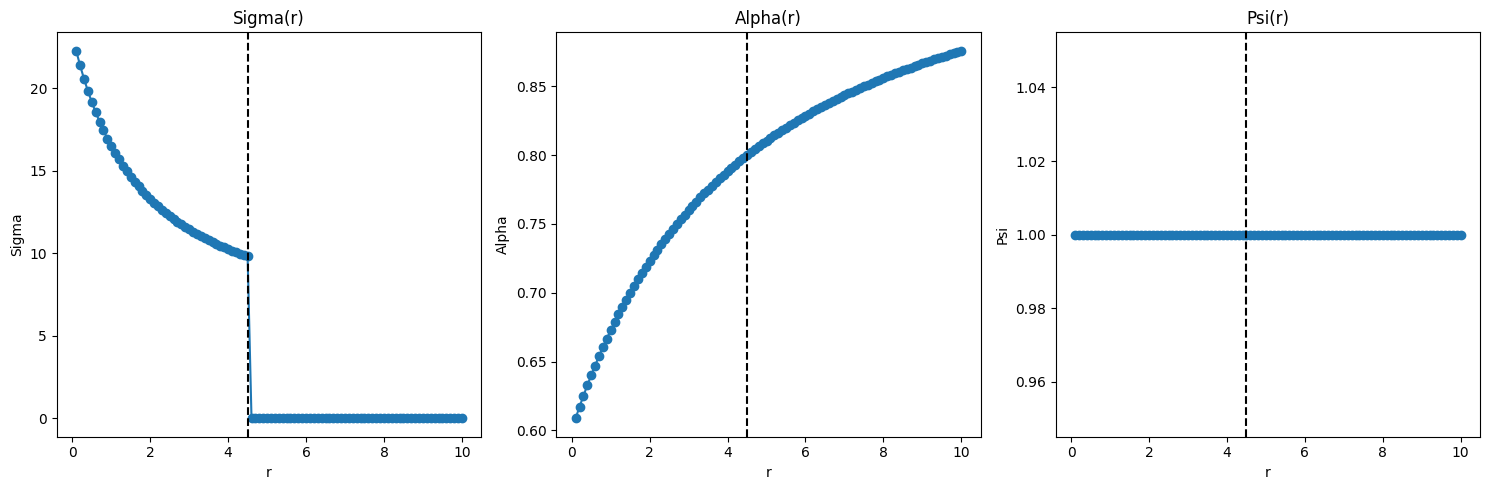

In [132]:
Rdisk.Visualize(Rdisk.ures)
Rdisk.Visualize1D(Rdisk.ures)
Rdisk.VisualizeSigmaAlphaPsi(Rdisk.sigma_old, Rdisk.alpha_old, Rdisk.psi_old)

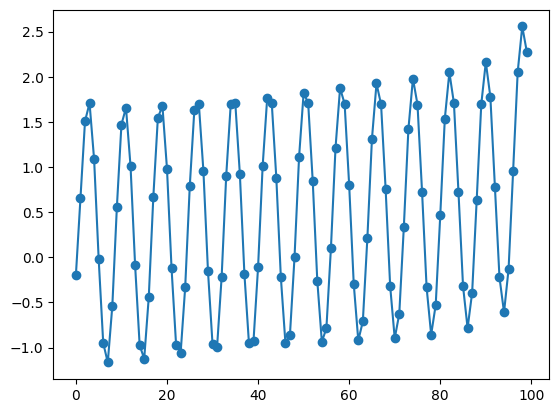

In [29]:
res2d = Rdisk.ures.reshape((Rdisk.Nr, Rdisk.Nz)).T
plt.plot(res2d[0,:], "-o")